<a href="https://colab.research.google.com/github/LorenzoTarricone/Mathemaical-Modelling-in-Machine-Learning/blob/main/08_KerasIntro_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

Keras is a high-level Deep Learning API that allows you to easily build, train, evaluate
and execute all sorts of neural networks. Its documentation (or specification) is available at https://keras.io. 

The reference implementation is simply called Keras as well, so to avoid any confusion we will call it keras-team (since it is available at https://
github.com/keras-team/keras). It was developed by François Chollet as part of a research project and released as an open source project in March 2015. It quickly gained popularity owing to its ease-of-use, flexibility and beautiful design. To perform the heavy computations required by neural networks, keras-team relies on a
computation backend. At the present, you can choose from three popular open source deep learning libraries: TensorFlow, Microsoft Cognitive Toolkit (CNTK) or Theano.

TensorFlow itself now comes bundled with its own Keras
implementation called tf.keras. It only supports TensorFlow as the backend, but it has
the advantage of offering some very useful extra features: for
example, it supports TensorFlow’s Data API which makes it quite easy to load and
preprocess data efficiently. For this reason, we will use tf.keras in this book. However,
in this chapter we will not use any of the TensorFlow-specific features, so the code
should run fine on other Keras implementations as well (at least in Python), with only
minor modifications, such as changing the imports

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Building an Image Classifier

First let's import TensorFlow and Keras.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Flatten

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
keras.__version__

'2.8.0'

## Fetch Data

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [ ]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [ ]:
X_train_full.dtype

dtype('uint8')

In [ ]:
X_train_full.max()

255

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

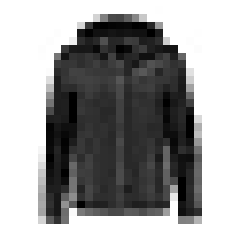

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [ ]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [ ]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

(5000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


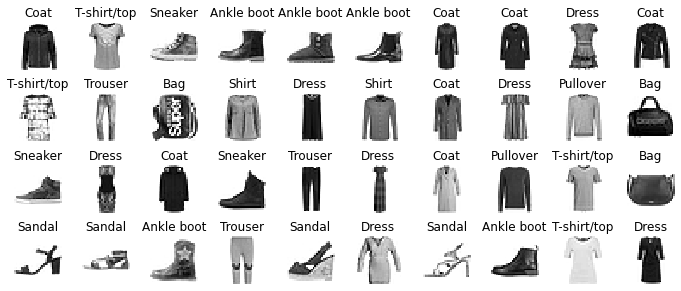

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## Build Model

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # input_shape doesn't include batch dimension (not aware of how many images i have), flatten layer is the input layer, we just take the 28x28 matrix and we turn into a vector of lenght 784
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10))

In [ ]:
keras.layers.Dense?

In [ ]:
model.layers

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hidden1 = model.layers[2] # access individual layers
hidden1.name

'dense_1'

In [ ]:
model.get_layer(hidden1.name) is hidden1

True

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights

array([[-0.09856108, -0.03964782, -0.10460811, ..., -0.11682571,
        -0.10988266, -0.08601865],
       [ 0.0120847 , -0.10815614, -0.04390524, ...,  0.05965982,
        -0.02137399,  0.03737056],
       [ 0.05106927,  0.08247524, -0.08934359, ..., -0.05715786,
         0.04638856,  0.02495176],
       ...,
       [ 0.07774975, -0.08349944,  0.11444516, ..., -0.00561196,
        -0.00261012, -0.05283229],
       [-0.09220524, -0.08243664, -0.10171043, ..., -0.10532185,
        -0.07465607, -0.0632925 ],
       [ 0.07635293, -0.11277272, -0.09716355, ..., -0.115454  ,
         0.11883067,  0.01952929]], dtype=float32)

In [ ]:
weights.shape

(300, 100)

In [ ]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
biases.shape

(100,)

## Compilation and Training 

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #This cross entropy works with not hot-encoded lables, from_logits=False if we use a softmax, we will use binary cross entropy with one final node for our task
              optimizer=keras.optimizers.SGD(learning_rate= 0.1, momentum= 0.5, nesterov= True),  #Stochastic Gradient Descent
              metrics=["accuracy"]) #This is monitored but not part of the optimization problem

This is equivalent to:

```python
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [ ]:
keras.optimizers.SGD?

In [ ]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2876 - accuracy: 0.8916 - val_loss: 0.3196 - val_accuracy: 0.8844
Epoch 2/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2766 - accuracy: 0.8956 - val_loss: 0.3086 - val_accuracy: 0.8848
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2658 - accuracy: 0.8988 - val_loss: 0.3005 - val_accuracy: 0.8858
Epoch 4/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2555 - accuracy: 0.9034 - val_loss: 0.3184 - val_accuracy: 0.8828
Epoch 5/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2500 - accuracy: 0.9055 - val_loss: 0.3663 - val_accuracy: 0.8784


In [ ]:
history.params

{'epochs': 5, 'steps': 1719, 'verbose': 1}

In [ ]:
type(history)

keras.callbacks.History

In [ ]:
print(history.epoch)

[0, 1, 2, 3, 4]


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


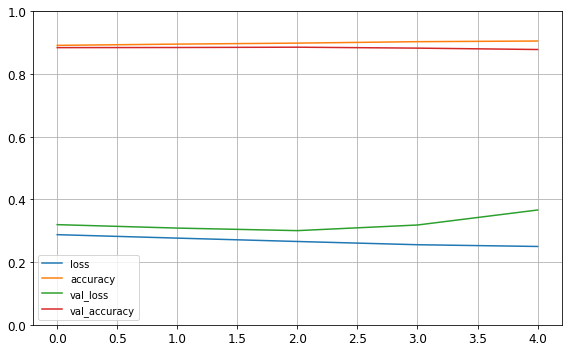

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

## Model Evaluation

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4075 - accuracy: 0.8650


0.8650000095367432

In [ ]:
X_new = X_test[:3]
y_proba = tf.nn.softmax(model.predict(X_new)).numpy()
y_proba.round(3) #Probability that the first 3 images fall in the corresponding 10 class 
#N.B: even if you've probability 1 by the model, the prediction could be completely wrong 

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.002, 0.   ,
        0.997],
       [0.   , 0.   , 0.964, 0.   , 0.032, 0.   , 0.004, 0.   , 0.   ,
        0.   ],
       [0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]], dtype=float32)

In [ ]:
y_pred = np.argmax(model.predict(X_new), axis=-1) #Works even with the logit ouput of the model
y_pred

array([9, 2, 1])

In [ ]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [ ]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


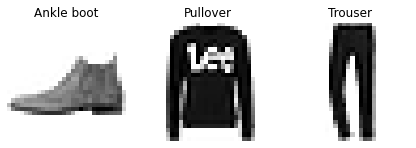

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

In [ ]:
?model.predict

## GPU Training

Keras/TensorFlow will make use of gpu accelerators if available. You can check if your machine has a CUDA gpu with

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
 tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

You can force using a specific device or cpu with 
```python
with tf.device('/gpu:0'):
    model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)
```
or setting
```python
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
```
before importing tensorflow.

# Functional API

The Functional API provides a more flexible alternative to Sequential API for model building. 
This is particularly useful when our model doesn't have a linear structure, e.g. has skip connections and concatenations.

In [ ]:
# model = keras.models.Sequential()
# model.add(Flatten(input_shape=[28, 28])) # input_shape doesn't include batch dimension
# model.add(Dense(300, activation="relu"))
# model.add(Dense(100, activation="relu"))
# model.add(Dense(10, activation="softmax"))

input_ = Input(shape=[28, 28]) # pass shape excluding batch dimension
x = Flatten()(input_)
x = keras.layers.Dense(300, activation="relu")(x)
x = keras.layers.Dense(100, activation="relu")(x)
output = keras.layers.Dense(10)(x)
model = keras.models.Model(inputs=[input_], outputs=[output])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=opt,
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4467 - accuracy: 0.8409 - val_loss: 0.3628 - val_accuracy: 0.8702
Epoch 2/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3602 - accuracy: 0.8685 - val_loss: 0.3582 - val_accuracy: 0.8718
Epoch 3/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3188 - accuracy: 0.8828 - val_loss: 0.3089 - val_accuracy: 0.8890
Epoch 4/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2991 - accuracy: 0.8888 - val_loss: 0.3097 - val_accuracy: 0.8884
Epoch 5/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2838 - accuracy: 0.8946 - val_loss: 0.2965 - val_accuracy: 0.8964


# Save and Load models

Save the entire model:

In [ ]:

model.save("my_keras_model")


model = keras.models.load_model("my_keras_model")

Save only the weight (useful for transfer learning):
What you do 


In [ ]:

model.save_weights("my_keras_weights.ckpt")

model.load_weights("my_keras_weights.ckpt")

# Callbacks

In [ ]:
?keras.callbacks.ModelCheckpoint

When I train care for the validation loss, the validation loss can go up again with overfitting, this method stops the process of learning when the validation loss increases again (or not degreases anymore)
- Avoids overfitting
- Saves time 

In [ ]:
?keras.callbacks.EarlyStopping

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model", save_best_only=True)

history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
1719/1719 [==============================] - 9s 4ms/step - loss: 0.4862 - accuracy: 0.8242 - val_loss: 0.3663 - val_accuracy: 0.8634
Epoch 2/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3646 - accuracy: 0.8656 - val_loss: 0.3729 - val_accuracy: 0.8622
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3295 - accuracy: 0.8778 - val_loss: 0.3251 - val_accuracy: 0.8804
Epoch 4/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3029 - accuracy: 0.8860 - val_loss: 0.3430 - val_accuracy: 0.8740
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2862 - accuracy: 0.8929 - val_loss: 0.3225 - val_accuracy: 0.8824


# Exercise 1

Change the labels of the FashionMNIST dataset setting the first 5 classes to 0 and the second 5 to 1.
Now we have a binary classification problem. Change the model architecture and loss function to solve the
problem and try to optimize the validation accuracy experimenting with hyperparameters.

Use the following code to change the labels.

In [ ]:
y_train_binary = y_train.copy()
y_valid_binary = y_valid.copy()
y_test_binary = y_test.copy()

for i in [0, 1, 2, 3, 4]:
    y_train_binary[y_train == i] = 0
    y_valid_binary[y_valid == i] = 0
    y_test_binary[y_test == i] = 0

for i in [5, 6, 7, 8, 9]:
    y_train_binary[y_train == i] = 1
    y_valid_binary[y_valid == i] = 1
    y_test_binary[y_test == i] = 1


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # input_shape doesn't include batch dimension (not aware of how many images i have), flatten layer is the input layer, we just take the 28x28 matrix and we turn into a vector of lenght 784
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(1))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  #This cross entropy works with not hot-encoded lables, from_logits=False if we use a softmax, we will use binary cross entropy with one final node for our task
              optimizer=keras.optimizers.SGD(learning_rate= 0.001, momentum = 0.5),  #Stochastic Gradient Descent
              metrics=["accuracy"]) #This is monitored but not part of the optimization problem

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model", save_best_only=True)

history = model.fit(X_train, y_train_binary, epochs=100,
                    validation_data=(X_valid, y_valid_binary),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3118 - accuracy: 0.8671 - val_loss: 0.2485 - val_accuracy: 0.8916
Epoch 2/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2407 - accuracy: 0.8942 - val_loss: 0.2244 - val_accuracy: 0.8974
Epoch 3/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2222 - accuracy: 0.8991 - val_loss: 0.2125 - val_accuracy: 0.9034
Epoch 4/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2112 - accuracy: 0.9054 - val_loss: 0.2052 - val_accuracy: 0.9058
Epoch 5/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2037 - accuracy: 0.9098 - val_loss: 0.2031 - val_accuracy: 0.9052
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1981 - accuracy: 0.9131 - val_loss: 0.1968 - val_accuracy: 0.9094
Epoch 7/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1938 - accuracy: 0.9146 - val_loss: 0.1926 - val_ac